In [ ]:
import bezier
import numpy as np

nodes = np.array([
     [0.0 ,  0.0],
     [0.25,  2.0],
     [0.5 , -2.0],
     [0.75,  2.0],
     [1.0 ,  0.3],
 ])
curve = bezier.Curve.from_nodes(nodes)

import matplotlib.pyplot as plt
%matplotlib notebook

curve.plot(num_pts=256)
plt.show()

In [ ]:
ax = plt.gca() 
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()
xy = np.vstack([x,y]).transpose()
#np.save('bezier_data.npy', xy)

In [1]:
import numpy as np
data = np.load('bezier_data.npy')
print data.shape

(256, 2)


<IPython.core.display.Javascript object>


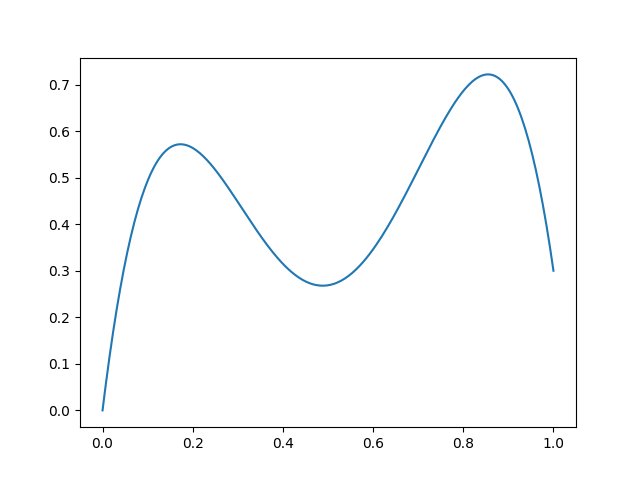

In [8]:
import matplotlib.pyplot as plt
%matplotlib notebook

x = data[:,0]
y = data[:,1]

plt.figure(2)
plt.plot(x, y)
plt.show()

In [3]:
from dmp import DMPs
import numpy as np

class DMPs_discrete(DMPs):
    """An implementation of discrete DMPs"""

    def __init__(self, **kwargs): 
        """
        """

        # call super class constructor
        super(DMPs_discrete, self).__init__(pattern='discrete', **kwargs)

        self.gen_centers()

        # set variance of Gaussian basis functions
        # trial and error to find this spacing
        self.h = np.ones(self.bfs) * self.bfs**1.5 / self.c

        self.check_offset()
        
    def gen_centers(self):
        """Set the centre of the Gaussian basis 
        functions be spaced evenly throughout run time"""

        '''x_track = self.cs.discrete_rollout()
        t = np.arange(len(x_track))*self.dt
        # choose the points in time we'd like centers to be at
        c_des = np.linspace(0, self.cs.run_time, self.bfs)
        self.c = np.zeros(len(c_des))
        for ii, point in enumerate(c_des): 
            diff = abs(t - point)
            self.c[ii] = x_track[np.where(diff == min(diff))[0][0]]'''

        # desired spacings along x
        # need to be spaced evenly between 1 and exp(-ax)
        # lowest number should be only as far as x gets 
        first = np.exp(-self.cs.ax*self.cs.run_time) 
        last = 1.05 - first
        des_c = np.linspace(first,last,self.bfs) 

        self.c = np.ones(len(des_c)) 
        for n in range(len(des_c)): 
            # x = exp(-c), solving for c
            self.c[n] = -np.log(des_c[n])

    def gen_front_term(self, x, dmp_num):
        """Generates the diminishing front term on 
        the forcing term.

        x float: the current value of the canonical system
        dmp_num int: the index of the current dmp
        """
        return x * (self.goal[dmp_num] - self.y0[dmp_num])

    def gen_goal(self, y_des): 
        """Generate the goal for path imitation. 
        For rhythmic DMPs the goal is the average of the 
        desired trajectory.
    
        y_des np.array: the desired trajectory to follow
        """

        return y_des[:,-1].copy()
    
    def gen_psi(self, x):
        """Generates the activity of the basis functions for a given 
        state of the canonical system.

        x float: the current state of the canonical system
        """
        
        return np.exp(-self.h * (x - self.c)**2)
        
    def gen_psi(self, x):
        """Generates the activity of the basis functions for a given 
        canonical system rollout. 
        
        x float, array: the canonical system state or path
        """
   
        if isinstance(x, np.ndarray):
            x = x[:,None]
        return np.exp(-self.h * (x - self.c)**2)

    def gen_weights(self, f_target):
        """Generate a set of weights over the basis functions such 
        that the target forcing term trajectory is matched.
        
        f_target np.array: the desired forcing term trajectory
        """

        # calculate x and psi   
        x_track = self.cs.rollout()
        psi_track = self.gen_psi(x_track)

        #efficiently calculate weights for BFs using weighted linear regression
        self.w = np.zeros((self.dmps, self.bfs))
        for d in range(self.dmps):
            # spatial scaling term
            k = (self.goal[d] - self.y0[d])
            for b in range(self.bfs):
                numer = np.sum(x_track * psi_track[:,b] * f_target[:,d])
                denom = np.sum(x_track**2 * psi_track[:,b])
                self.w[d,b] = numer / (k * denom)

<IPython.core.display.Javascript object>


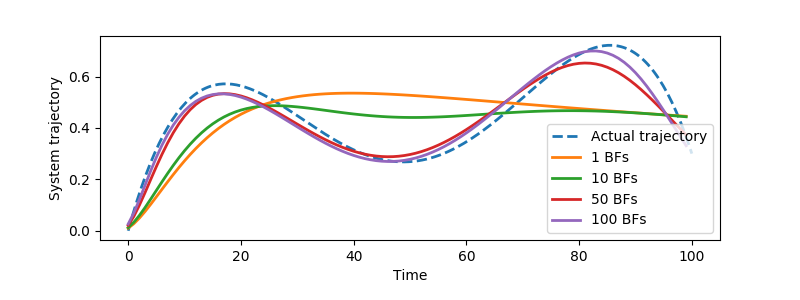

In [4]:
# true value
x = data[:,0] * 100
y = data[:,1]

import matplotlib
#matplotlib.rcParams.update({'font.size': 10})

num_bfs = [1, 10, 50, 100]
plt.figure(3,figsize=(8,3))
plt.plot(x, y, '--', lw=2)

for ii, bfs in enumerate(num_bfs):
    dmp = DMPs_discrete(dmps=1, bfs=bfs)
    dmp.imitate_path(y_des=y)
    y_track,dy_track,ddy_track = dmp.rollout()

    plt.plot(y_track[:,0], lw=2)

plt.xlabel('Time')
plt.ylabel('System trajectory')
legengs_list = ['Actual trajectory'] + ['%i BFs'%i for i in num_bfs]
plt.legend(legengs_list, loc='lower right')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('DMP_BFs.pdf')
plt.show()

<IPython.core.display.Javascript object>


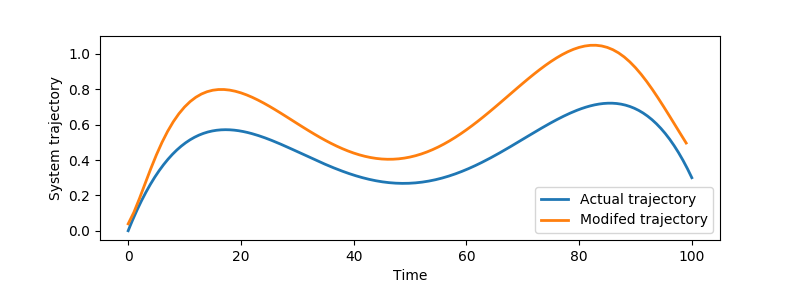

In [5]:
x = data[:,0] * 100
y = data[:,1]

dmp = DMPs_discrete(dmps=1, bfs=100)
dmp.imitate_path(y_des=y)
dmp.goal[0] = y[-1] * 1.5
y_track,dy_track,ddy_track = dmp.rollout()

plt.figure(4,figsize=(8,3))
plt.plot(x, y, lw=2)
plt.plot(y_track[:,0], lw=2)

plt.xlabel('Time')
plt.ylabel('System trajectory')
legengs_list = ['Actual trajectory', 'Modifed trajectory']
plt.legend(legengs_list, loc='lower right')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('DMP_Goal.pdf')
plt.show()

In [6]:
y.shape
print y[-1], (y[-1]*1.5)

0.3 0.45


In [7]:
mod_y = y_track[:,0]
print dmp.goal[0], mod_y[-1]

0.45 0.49619347418
